In [1]:
pip install lightgbm

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simpleNote: you may need to restart the kernel to use updated packages.



In [2]:
pip install xgboost

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error,mean_absolute_error, f1_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.linear_model import LinearRegression as lr
from sklearn.model_selection import  KFold, StratifiedKFold,GroupKFold, RepeatedKFold
import warnings
import seaborn as sns
warnings.filterwarnings('ignore') #消除warning

In [4]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("testA.csv")
print(train_data.shape)
print(test_data.shape)


(800000, 47)
(200000, 46)


In [5]:
#由于等下需要对特征进行变化，因此我先将训练集和测试集堆叠在一起，一起处理才方便，再加入一列作为区分即可
target = train_data["isDefault"]
train_data["origin"] = "train"
test_data["origin"] = "test"
del train_data["isDefault"]

data = pd.concat([train_data, test_data], axis = 0, ignore_index = True)
data.shape


(1000000, 47)

In [6]:
#那么接下来就是对data进行处理，可以先看看其大致的信息：
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 47 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1000000 non-null  int64  
 1   loanAmnt            1000000 non-null  float64
 2   term                1000000 non-null  int64  
 3   interestRate        1000000 non-null  float64
 4   installment         1000000 non-null  float64
 5   grade               1000000 non-null  object 
 6   subGrade            1000000 non-null  object 
 7   employmentTitle     999999 non-null   float64
 8   employmentLength    941459 non-null   object 
 9   homeOwnership       1000000 non-null  int64  
 10  annualIncome        1000000 non-null  float64
 11  verificationStatus  1000000 non-null  int64  
 12  issueDate           1000000 non-null  object 
 13  purpose             1000000 non-null  int64  
 14  postCode            999999 non-null   float64
 15  regionCode      

[Text(0, 0, 'employmentTitle'),
 Text(1, 0, 'postCode'),
 Text(2, 0, 'title'),
 Text(3, 0, 'dti'),
 Text(4, 0, 'pubRecBankruptcies'),
 Text(5, 0, 'revolUtil'),
 Text(6, 0, 'n10'),
 Text(7, 0, 'n4'),
 Text(8, 0, 'n12'),
 Text(9, 0, 'n9'),
 Text(10, 0, 'n7'),
 Text(11, 0, 'n6'),
 Text(12, 0, 'n3'),
 Text(13, 0, 'n13'),
 Text(14, 0, 'n2'),
 Text(15, 0, 'n1'),
 Text(16, 0, 'n0'),
 Text(17, 0, 'n5'),
 Text(18, 0, 'n14'),
 Text(19, 0, 'n8'),
 Text(20, 0, 'employmentLength'),
 Text(21, 0, 'n11')]

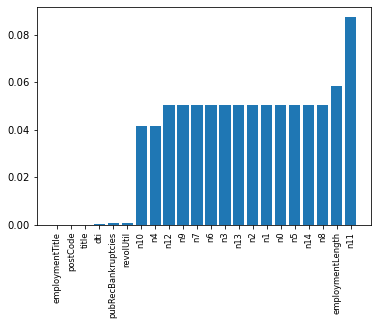

In [7]:
#最重要的是对缺失值和异常值的处理，那么来看看哪些特征的缺失值和异常值最多：
missing = data.isnull().sum() / len(data)
missing = missing[missing > 0 ]
missing.sort_values(inplace = True)#排序并替换原来的数据
x = np.arange(len(missing))
fig, ax = plt.subplots()#创建多维窗口
ax.bar(x,missing)#绘制竖状条形图
ax.set_xticks(x)#设置刻度
ax.set_xticklabels(list(missing.index), rotation = 90, fontsize = "small")


In [8]:
print(sorted(data['grade'].unique()))
print(sorted(data['subGrade'].unique()))


['A', 'B', 'C', 'D', 'E', 'F', 'G']
['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


In [9]:
data['employmentLength'].value_counts(dropna=False).sort_index()


1 year        65671
10+ years    328525
2 years       90565
3 years       80163
4 years       59818
5 years       62645
6 years       46582
7 years       44230
8 years       45168
9 years       37866
< 1 year      80226
NaN           58541
Name: employmentLength, dtype: int64

In [10]:
# 对employmentLength该列进行处理
data["employmentLength"].replace(to_replace="10+ years", value = "10 years",
                                      inplace = True)
data["employmentLength"].replace(to_replace="< 1 year", value = "0 years",
                                      inplace = True)
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s # 如果是nan还是nan
    else:
        return np.int8(s.split()[0])  # 按照空格分隔得到第一个字符
    
data["employmentLength"] = data["employmentLength"].apply(employmentLength_to_int)


In [11]:
data["employmentLength"]

0          2.0
1          5.0
2          8.0
3         10.0
4          NaN
          ... 
999995     7.0
999996     1.0
999997     8.0
999998     4.0
999999     7.0
Name: employmentLength, Length: 1000000, dtype: float64

In [12]:
data['earliesCreditLine'].sample(5)


175048    Dec-2004
258180    Oct-2000
204889    Jan-1990
544186    Nov-2004
654307    Apr-2000
Name: earliesCreditLine, dtype: object

In [13]:
data["earliesCreditLine"] = data["earliesCreditLine"].apply(lambda x:int(x[-4:]))


In [14]:
data['earliesCreditLine'].value_counts(dropna=False).sort_index()


1944        2
1945        1
1946        2
1949        1
1950        7
        ...  
2011    12282
2012     8304
2013     4375
2014     1863
2015      251
Name: earliesCreditLine, Length: 70, dtype: int64

In [15]:
cate_features = ["grade",
                "subGrade",
                "employmentTitle",
                "homeOwnership",
                "verificationStatus",
                "purpose",
                "postCode",
                "regionCode",
                "applicationType",
                "initialListStatus",
                "title",
                "policyCode"]
for fea in cate_features:
    print(fea, " 类型数目为：", data[fea].nunique())


grade  类型数目为： 7
subGrade  类型数目为： 35
employmentTitle  类型数目为： 298101
homeOwnership  类型数目为： 6
verificationStatus  类型数目为： 3
purpose  类型数目为： 14
postCode  类型数目为： 935
regionCode  类型数目为： 51
applicationType  类型数目为： 2
initialListStatus  类型数目为： 2
title  类型数目为： 47903
policyCode  类型数目为： 1


In [16]:
data = pd.get_dummies(data, columns = ['grade', 'subGrade', 
                                             'homeOwnership', 'verificationStatus', 
                                             'purpose', 'regionCode'],
                     drop_first = True)
# drop_first就是k个类别，我只用k-1个来表示，那个没有表示出来的类别就是全0


In [17]:
# 高维类别特征需要进行转换
for f in ['employmentTitle', 'postCode', 'title']:
    data[f+'_cnts'] = data.groupby([f])['id'].transform('count')
    data[f+'_rank'] = data.groupby([f])['id'].rank(ascending=False).astype(int)
    del data[f]
    
# cnts的意思就是：对f特征的每一个取值进行计数，例如取值A有3个，B有5个，C有7个
# 那么那些f特征取值为A的，在cnt中就是取值为3，B的就是5，C的就是7
# 而rank就是对取值为A的三个排序123，对B的排12345，C的排1234567，各个取值内部排序
# 然后ascending=False就是从后面开始给，最后一个取值为A的给1，倒数第二个给2，倒数第三个给3


In [18]:
data.shape


(1000000, 154)

In [19]:
train = data[data["origin"] == "train"].reset_index(drop=True)
test = data[data["origin"] == "test"].reset_index(drop=True)
features = [f for f in data.columns if f not in ['id','issueDate','isDefault',"origin"]]  # 这些特征不用参与训练
x_train = train[features]
y_train = target
x_test = test[features]


In [20]:
lgb_params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'verbosity': 1,
                'verbose': -1,
            }
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
valid_lgb = np.zeros(len(x_train))
predict_lgb = np.zeros(len(x_test))
for fold_, (train_idx,valid_idx) in enumerate(folds.split(x_train, y_train)):
    print("当前第{}折".format(fold_ + 1))
    train_data_now = lgb.Dataset(x_train.iloc[train_idx], y_train[train_idx])
    valid_data_now = lgb.Dataset(x_train.iloc[valid_idx], y_train[valid_idx])
    watchlist = [(train_data_now,"train"), (valid_data_now, "valid_data")]
    num_round = 10000
    lgb_model = lgb.train(lgb_params, train_data_now, num_round, 
                        valid_sets=[train_data_now, valid_data_now], verbose_eval=500,
                       early_stopping_rounds = 800)
    valid_lgb[valid_idx] = lgb_model.predict(lgb.Dataset(x_train.iloc[valid_idx]),
                                           ntree_limit = lgb_model.best_iteration)
    predict_lgb += lgb_model.predict(lgb.Dataset(x_test), num_iteration=
                                           lgb_model.best_iteration) / folds.n_splits


当前第1折
[LightGBM] [Warning] num_threads is set with nthread=28, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] num_threads is set with nthread=28, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Info] Number of positive: 127688, number of negative: 512312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.634180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4407
[LightGBM] [Info] Number of data points in the train set: 640000, number of used features: 149
[LightGBM] [Warning] num_threads is set with nthread=28, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Curren

TypeError: Cannot use Dataset instance for prediction, please use raw data instead

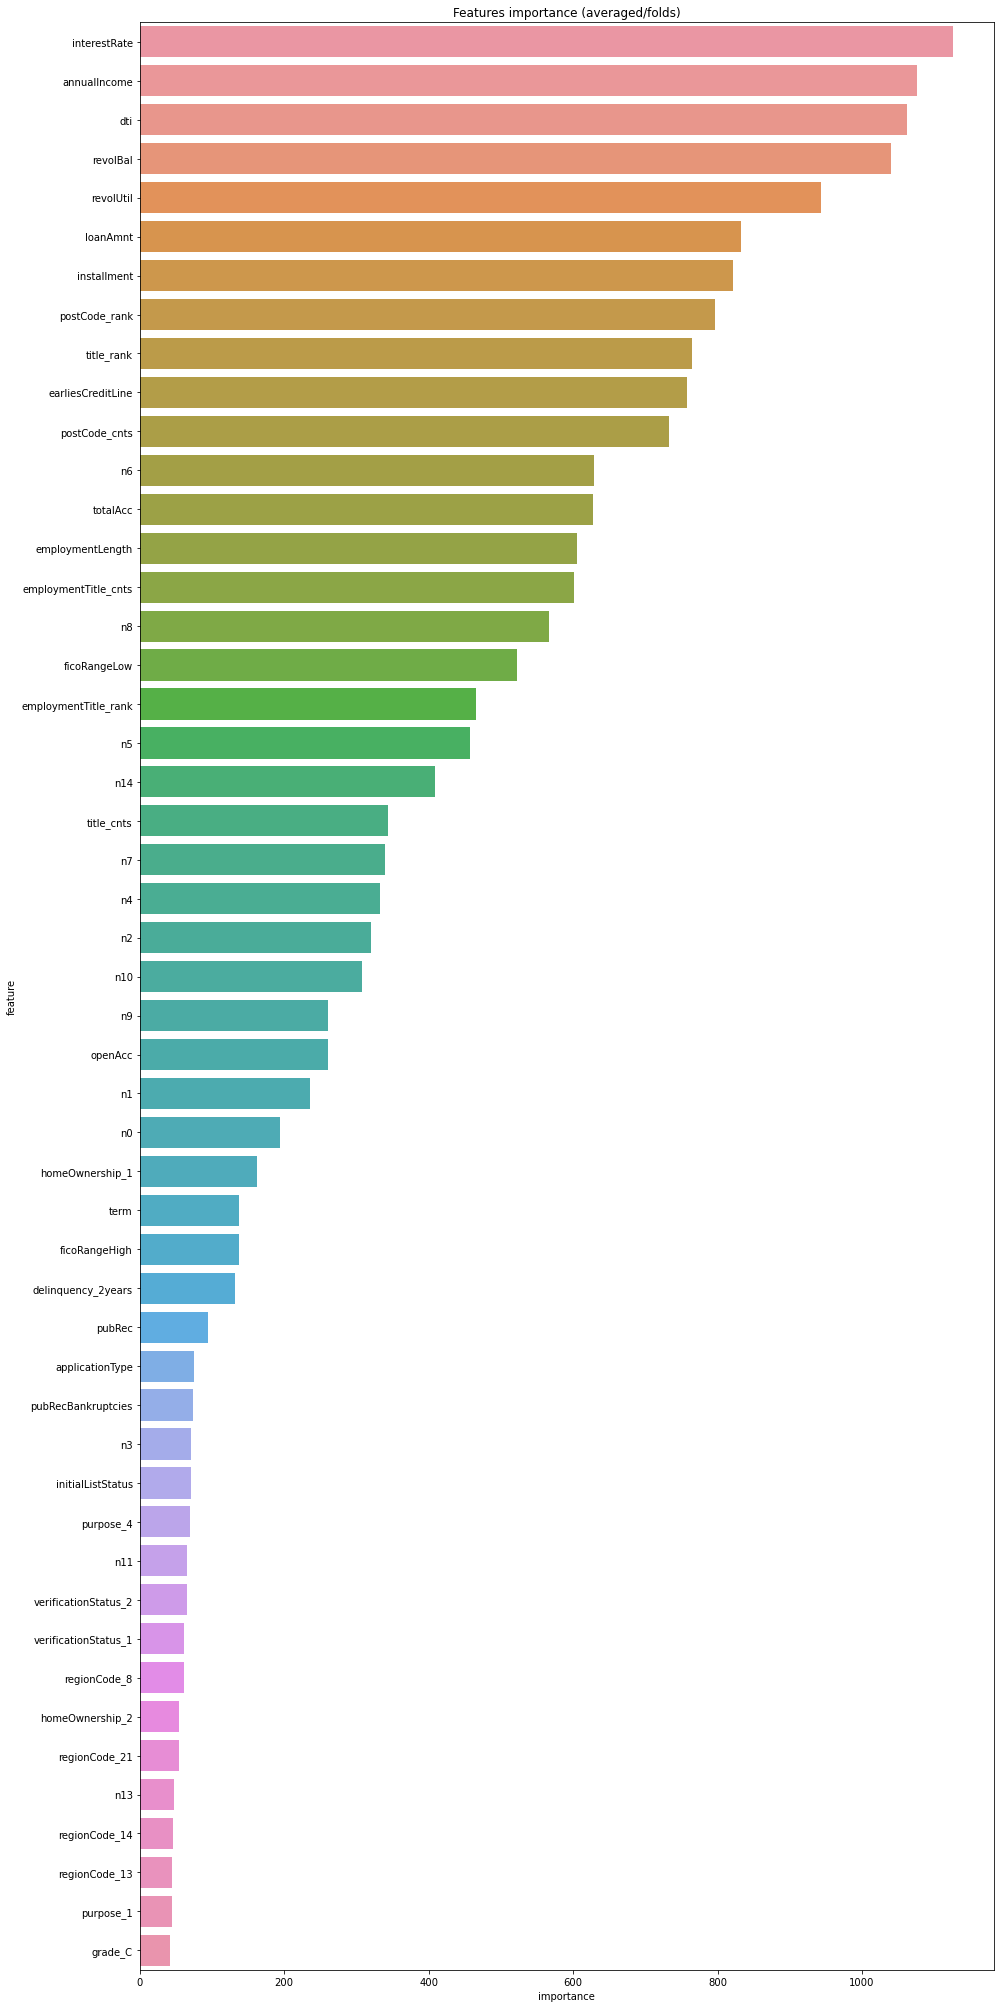

In [21]:
pd.set_option("display.max_columns", None)  # 设置可以显示的最大行和最大列
pd.set_option('display.max_rows', None)  # 如果超过就显示省略号，none表示不省略
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)
df = pd.DataFrame(data[features].columns.tolist(), columns=['feature'])
df['importance'] = list(lgb_model.feature_importance())
df = df.sort_values(by = "importance", ascending=False)
plt.figure(figsize = (14,28))#指定宽和高
sns.barplot(x = 'importance', y = 'feature', data = df.head(50))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()  # 自动调整适应范围


In [ ]:
# xgboost模型

xgb_params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 1,
                      'nthread': 36,
                      "verbosity": 1,
                      }
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
valid_xgb = np.zeros(len(x_train))
predict_xgb = np.zeros(len(x_test))
for fold_, (train_idx,valid_idx) in enumerate(folds.split(x_train, y_train)):
    print("当前第{}折".format(fold_ + 1))
    train_data_now = xgb.DMatrix(x_train.iloc[train_idx], y_train[train_idx])
    valid_data_now = xgb.DMatrix(x_train.iloc[valid_idx], y_train[valid_idx])
    watchlist = [(train_data_now,"train"), (valid_data_now, "valid_data")]
    xgb_model = xgb.train(dtrain = train_data_now, num_boost_round = 3000,
                         evals = watchlist, early_stopping_rounds = 500,
                         verbose_eval = 500, params = xgb_params)
    valid_xgb[valid_idx] =xgb_model.predict(xgb.DMatrix(x_train.iloc[valid_idx]),
                                           ntree_limit = xgb_model.best_ntree_limit)
    predict_xgb += xgb_model.predict(xgb.DMatrix(x_test),ntree_limit 
                                     = xgb_model.best_ntree_limit) / folds.n_splits
   


当前第1折
[0]	train-auc:0.69258	valid_data-auc:0.69102
[500]	train-auc:0.73854	valid_data-auc:0.72651


In [ ]:
#逻辑回归
# 模型融合
train_stack = np.vstack([valid_lgb, valid_xgb]).transpose()
test_stack = np.vstack([predict_lgb, predict_xgb]).transpose()
folds_stack = RepeatedKFold(n_splits = 5, n_repeats = 2, random_state = 1)
valid_stack = np.zeros(train_stack.shape[0])
predict_lr2 = np.zeros(test_stack.shape[0])

for fold_, (train_idx, valid_idx) in enumerate(folds_stack.split(train_stack, target)):
    print("当前是第{}折".format(fold_+1))
    train_x_now, train_y_now = train_stack[train_idx], target.iloc[train_idx].values
    valid_x_now, valid_y_now = train_stack[valid_idx], target.iloc[valid_idx].values
    lr2 = lr()
    lr2.fit(train_x_now, train_y_now)
    valid_stack[valid_idx] = lr2.predict(valid_x_now)
    predict_lr2 += lr2.predict(test_stack) / 10
    
print("score:{:<8.8f}".format(roc_auc_score(target, valid_stack)))


In [ ]:
testA = pd.read_csv("testA.csv")
testA['isDefault'] = predict_lr2
submission_data = testA[['id','isDefault']]
submission_data.to_csv("myresult.csv",index = False)
